# Statistical analysis describing the use of the BlueBikes system in Boston, Cambridge, Brookline, and Sommerville

Boston is considered a bike-friendly city. Its Bike-Sharing System (BSS) program was launched in 2011. Since then, the system has grown over the years. The trip data provided by BlueBikes (the Boston's BSS company) has nearly 8 million trips until October 2018. This notebook analyzes this data to understand what are the usage patterns of the system including age, trip distance, trip duration and, average speed. Moreover, the notebook also presents a time-series analysis that shows the evolution of trips over the years.

Thus, this notebook answer the following questions:

- How many trips occurred through the years?
- What is the average distance rode by users?
- How long do the trips last?
- What is the average age of users?
- What is the average speed of women and men?

In [7]:
import pandas as pd
import numpy as np
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact, widgets
# import geopandas as gpd
# from shapely.geometry import Point
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdate
import seaborn as sbn
#import bikescience.load_trips as tr
#import bikescience.distributions as dist
#import bikescience.charts as ch
import scipy.stats as st
pd.set_option('precision', 1)
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18

### Loading all bike trips

In [9]:
trips = load_all_trips('../2013-bluebikes-tripdata')
# Data cleaning: station id 164 is only for tests. It has no latitude / longitude
trips = trips[(trips['end station latitude'] != 0) & 
              (trips['end station longitude'] != 0) &
              (trips['start station latitude'] != 0) & 
              (trips['start station longitude'] != 0)]

NameError: name 'load_all_trips' is not defined

### Preparing datasets to create charts for age, trip duration, distance, and speed

In [4]:
# Age distribution
try:
    tage = trips[(trips["birth year"] != '\\N')]
except TypeError:
        pass
tage = tage.dropna()
tage["birth year"] = tage["birth year"].astype(int)
tage = tage[(tage["birth year"] != 1969) & (tage["birth year"] > 1934)]
tage["age"] = 2018 - tage["birth year"]
tage = tage[['age']]

# Trip duration
duration = trips[trips['tripduration'] < 3000]
duration = duration[['tripduration']]

# Distance
#Here we used a preprocessed file that was based in the GraphHoper algorithm to calculate distance
stations_distances = pd.read_csv('../data/boston/bike-stations/stations_distances.csv', index_col=['id_x', 'id_y'])
trips = trips.merge(stations_distances, left_on=['start station id', 'end station id'], right_index=True)
distance = trips[(trips.distance<10) & (trips.distance>0)]
distance = distance[['distance']]

# Speed by gender
#calculating speed
trips['speed'] = trips['distance']/trips['tripduration']*3600
#splitting by gender
gender = trips[trips['gender'] != 0].copy()
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
gender = gender[['gender','distance','tripduration','speed']]
women_speed = gender[(gender.gender == 2) & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 1) & (gender.speed> 0) & (gender.speed < 30)].speed

### Figure 1: descriptive statistics with the trip distributions for age, trip duration, distance and speed by gender  

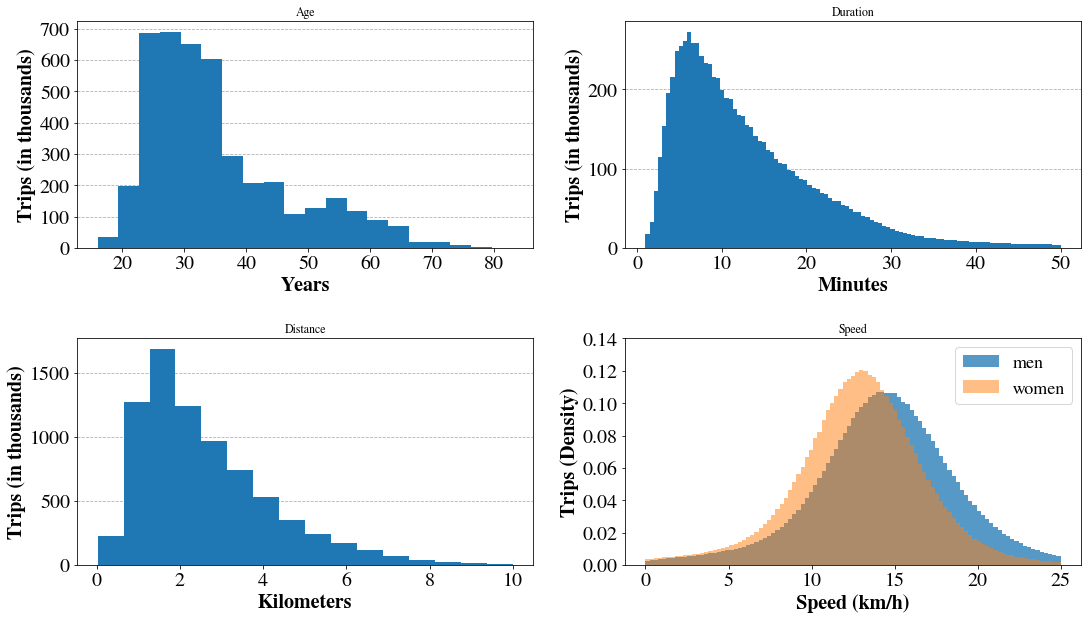

In [5]:
fig, axes = plt.subplots(2,2,figsize=(18,10))
plt.subplots_adjust(hspace=0.4)
#age
axes[0,0].set_axisbelow(True)
axes[0,0].grid(linestyle='--')
axes[0,0].xaxis.grid(False)
axes[0,0].set_title('Age')
axes[0,0].set_xlabel('Years')
axes[0,0].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[0,0].yaxis.set_major_formatter(formatter)
axes[0,0].set_xticks(np.arange(20,81,step=10))
axes[0,0].set_yticks(np.arange(0,700001,step=100000))
axes[0,0].hist(bins=20,x=tage['age'])

#duration
axes[0,1].set_axisbelow(True)
axes[0,1].grid(linestyle='--')
axes[0,1].xaxis.grid(False)
axes[0,1].set_title('Duration')
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[0,1].yaxis.set_major_formatter(formatter)
axes[0,1].hist(bins=100,x=duration['tripduration']/60)

#distance
axes[1,0].set_axisbelow(True)
axes[1,0].grid(linestyle='--')
axes[1,0].xaxis.grid(False)
axes[1,0].set_title('Distance')
axes[1,0].set_xlabel('Kilometers')
axes[1,0].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[1,0].yaxis.set_major_formatter(formatter)
axes[1,0].hist(bins=16,x=distance['distance'])

# speed
bins = np.linspace(0, 25, 100)
axes[1,1].xaxis.grid(False)
axes[1,1].yaxis.grid(False)
axes[1,1].hist(men_speed, bins, alpha=0.75, label='men', density=True)
axes[1,1].hist(women_speed, bins, alpha=0.5, label='women', density=True)
axes[1,1].legend(loc='upper right')
axes[1,1].set_title('Speed')
axes[1,1].set_xlabel('Speed (km/h)')
axes[1,1].set_ylabel('Trips (Density)')
axes[1,1].set_yticks(np.arange(0,0.15,step=0.02))

plt.savefig('charts/figure1.pdf', format='pdf', dpi=200)

### Creating a dataset for the time series analysis

In [6]:
#indexing by datetime
trip_time_series = trips.copy()
trip_time_series['dateindex'] = pd.to_datetime(trip_time_series['starttime'])
trip_time_series = trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['dateindex']))
trip_time_series = trip_time_series[['dateindex','gender']]

#getting daily average per month
trips_day_average = trip_time_series['dateindex'].groupby(pd.Grouper(freq='D')).count()
trips_per_day = trips_day_average.groupby(pd.Grouper(freq='M')).agg({'mean':'mean','std':'std'})

#bike use ratio between men and women
women_trips = trip_time_series[(trip_time_series.gender == 2)]
men_trips = trip_time_series[(trip_time_series.gender == 1)]

women_trips_day_count = women_trips['dateindex'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['dateindex'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='M')).agg({'sum':'sum'})
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='M')).agg({'sum':'sum'})

ratio_men_women_per_month = men_trips_per_month.copy()
ratio_men_women_per_month['women'] = women_trips_per_month['sum']
ratio_men_women_per_month.rename(columns={'sum':'men'},inplace=True)
ratio_men_women_per_month['ratio'] = ratio_men_women_per_month['men']/ratio_men_women_per_month['women']

####filtering from April 2013, the first month without 
trips_per_day = trips_per_day[((trips_per_day.index.year == 2013) & (trips_per_day.index.month >= 4)) 
                              | (trips_per_day.index.year > 2013)]

ratio_men_women_per_month = ratio_men_women_per_month[((ratio_men_women_per_month.index.year == 2013) 
                                                       & (ratio_men_women_per_month.index.month >= 4)) 
                                                        | (ratio_men_women_per_month.index.year > 2013)]

#calculating the 12-month rolling average
trips_12_month_rolling = trips_per_day.sort_index().rolling(12).mean().dropna()

/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


### Figure 2: Trips per month and gender with day usage average, standard deviation, and 12-month rolling

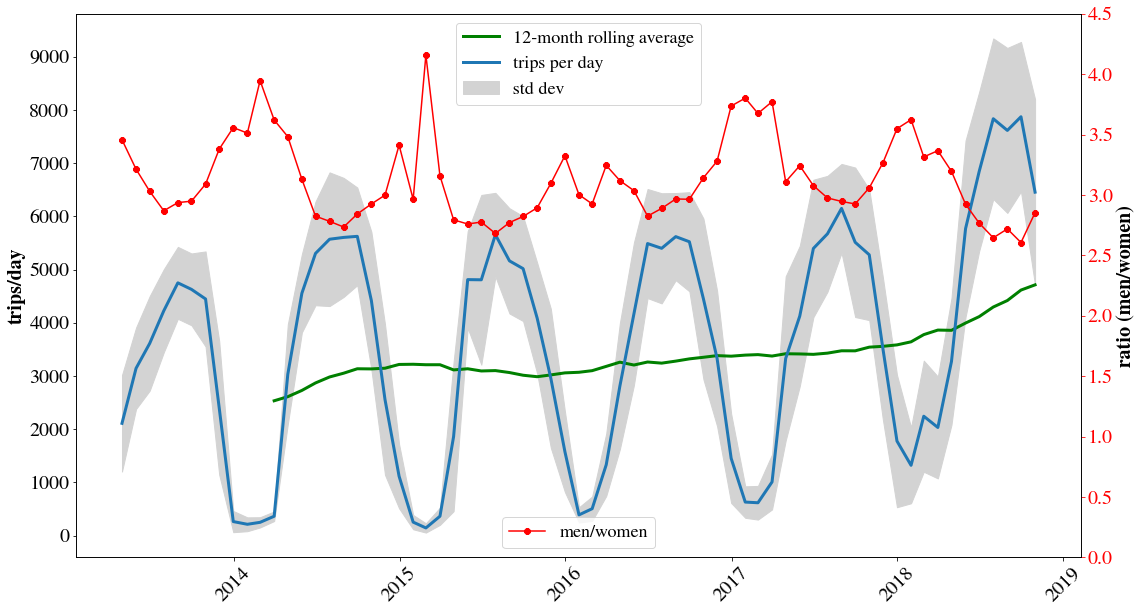

In [7]:
dateFmt = mdate.DateFormatter('%Y')
ax_day_avg_gender = plt.axes()
ax_day_avg_gender.set_axisbelow(True)
ax_day_avg_gender.xaxis.grid(False)
ax_day_avg_gender.yaxis.grid(False)
ax_day_avg_gender.plot(trips_12_month_rolling['mean'],label='12-month rolling average',linewidth=3,color='green')
ax_day_avg_gender.plot(trips_per_day['mean'],label='trips per day',linewidth=3)
ax_day_avg_gender.figure.set_size_inches(18,10)
ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_day.index,trips_per_day['mean']-trips_per_day['std'],
                 trips_per_day['mean']+trips_per_day['std'],color='lightgray',label='std dev')
plt.legend(loc='upper center')
ax_ratio_gender = ax_day_avg_gender.twinx()
ax_ratio_gender.plot(ratio_men_women_per_month.index,ratio_men_women_per_month['ratio'],label='men/women',color='red',marker='8')
ax_ratio_gender.set_ylabel('ratio (men/women)')
ax_ratio_gender.yaxis.grid(False)
ax_ratio_gender.xaxis.set_major_formatter(dateFmt)
ax_ratio_gender.set_yticks(np.arange(0,5.0,step=0.5))
ax_ratio_gender.legend(loc='lower center')
ax_ratio_gender.tick_params('y',colors='red')

plt.savefig('charts/figure2.pdf', format='pdf', dpi=200)
plt.draw()